# Training Pre-trained SSD Model on GEE Dataset

## Imports

In [9]:
import os
os.chdir('/home/jupyter/ee_tree_counting/Models/SSD')

In [10]:
from config import (
    DEVICE, 
    NUM_CLASSES, 
    NUM_EPOCHS, 
    OUT_DIR,
    VISUALIZE_TRANSFORMED_IMAGES, 
    NUM_WORKERS,
    RESIZE_TO
)
from model import create_model
from custom_utils import (
    Averager, 
    SaveBestModel, 
    save_model, 
    save_loss_plot,
    save_mAP
)
from tqdm.auto import tqdm
from datasets import (
    create_train_dataset, 
    create_valid_dataset, 
    create_train_loader, 
    create_valid_loader
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.optim.lr_scheduler import StepLR

import torch
import matplotlib.pyplot as plt
import time
import os
import csv

plt.style.use('ggplot')

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## Training and Validation Functions

In [11]:
# Function for running training iterations.
def train(train_data_loader, model):
    print('Training')
    model.train()
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value

In [12]:
def validate(valid_data_loader, model):
    print('Validating')
    model.eval()
    
    # Initialize tqdm progress bar.
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    target = []
    preds = []
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            outputs = model(images, targets)

        # For mAP calculation using Torchmetrics.
        #####################################
        for i in range(len(images)):
            true_dict = dict()
            preds_dict = dict()
            true_dict['boxes'] = targets[i]['boxes'].detach().cpu()
            true_dict['labels'] = targets[i]['labels'].detach().cpu()
            preds_dict['boxes'] = outputs[i]['boxes'].detach().cpu()
            preds_dict['scores'] = outputs[i]['scores'].detach().cpu()
            preds_dict['labels'] = outputs[i]['labels'].detach().cpu()
            preds.append(preds_dict)
            target.append(true_dict)
        #####################################

    metric = MeanAveragePrecision()
    metric.update(preds, target)
    metric_summary = metric.compute()
    return metric_summary

## Loading the Pre-trained Model

In [13]:
# Update the paths to point to your geospatial dataset
TRAIN_DIR = "/home/jupyter/ee_tree_counting/Data/GEE Dataset/Dataset XML/train"
VALID_DIR = "/home/jupyter/ee_tree_counting/Data/GEE Dataset/Dataset XML/valid"

# Path to the pre-trained model weights
PRETRAINED_WEIGHTS_PATH = "/home/jupyter/ee_tree_counting/Models/SSD/outputs/Custom Dataset No Aug/best_model.pth"

NUM_EPOCH = 100


In [14]:
model = create_model(num_classes=NUM_CLASSES, size=RESIZE_TO)
checkpoint = torch.load(PRETRAINED_WEIGHTS_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
# model.to(DEVICE).eval()
model.to(DEVICE).train()


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

# Dataloaders and Optimiser

In [15]:
train_dataset = create_train_dataset(TRAIN_DIR)
valid_dataset = create_valid_dataset(VALID_DIR)
train_loader = create_train_loader(train_dataset, NUM_WORKERS)
valid_loader = create_valid_loader(valid_dataset, NUM_WORKERS)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, nesterov=True)
scheduler = StepLR(
    optimizer=optimizer, step_size=15, gamma=0.1, verbose=True
)

Number of training samples: 49
Number of validation samples: 15

23,745,908 total parameters.
23,745,908 training parameters.
Adjusting learning rate of group 0 to 1.0000e-04.


/opt/conda/lib/python3.10/site-packages/albumentations/core/composition.py:156: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


# Training Loop


EPOCH 1 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch #1 train loss: 3.702
Epoch #1 mAP@0.5: 37.69%
Epoch #1 mAP@0.5:0.95: 14.49%
Took 0.048 minutes for epoch 0

BEST VALIDATION mAP: 0.144868865609169

SAVING BEST MODEL FOR EPOCH: 1

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 2 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #2 train loss: 3.458
Epoch #2 mAP@0.5: 48.21%
Epoch #2 mAP@0.5:0.95: 19.82%
Took 0.046 minutes for epoch 1

BEST VALIDATION mAP: 0.19820041954517365

SAVING BEST MODEL FOR EPOCH: 2

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 3 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #3 train loss: 3.312
Epoch #3 mAP@0.5: 54.21%
Epoch #3 mAP@0.5:0.95: 23.20%
Took 0.047 minutes for epoch 2

BEST VALIDATION mAP: 0.23195603489875793

SAVING BEST MODEL FOR EPOCH: 3

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 4 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #4 train loss: 3.193
Epoch #4 mAP@0.5: 57.90%
Epoch #4 mAP@0.5:0.95: 24.87%
Took 0.047 minutes for epoch 3

BEST VALIDATION mAP: 0.2487359195947647

SAVING BEST MODEL FOR EPOCH: 4

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 5 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #5 train loss: 3.109
Epoch #5 mAP@0.5: 59.38%
Epoch #5 mAP@0.5:0.95: 25.80%
Took 0.049 minutes for epoch 4

BEST VALIDATION mAP: 0.2580004036426544

SAVING BEST MODEL FOR EPOCH: 5

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 6 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #6 train loss: 3.033
Epoch #6 mAP@0.5: 62.85%
Epoch #6 mAP@0.5:0.95: 27.29%
Took 0.047 minutes for epoch 5

BEST VALIDATION mAP: 0.272943377494812

SAVING BEST MODEL FOR EPOCH: 6

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 7 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #7 train loss: 3.001
Epoch #7 mAP@0.5: 65.38%
Epoch #7 mAP@0.5:0.95: 29.03%
Took 0.051 minutes for epoch 6

BEST VALIDATION mAP: 0.2903016209602356

SAVING BEST MODEL FOR EPOCH: 7

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 8 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #8 train loss: 2.918
Epoch #8 mAP@0.5: 67.04%
Epoch #8 mAP@0.5:0.95: 30.42%
Took 0.048 minutes for epoch 7

BEST VALIDATION mAP: 0.3041648864746094

SAVING BEST MODEL FOR EPOCH: 8

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 9 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #9 train loss: 2.902
Epoch #9 mAP@0.5: 68.22%
Epoch #9 mAP@0.5:0.95: 31.56%
Took 0.047 minutes for epoch 8

BEST VALIDATION mAP: 0.3155933916568756

SAVING BEST MODEL FOR EPOCH: 9

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 10 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #10 train loss: 2.863
Epoch #10 mAP@0.5: 69.00%
Epoch #10 mAP@0.5:0.95: 32.08%
Took 0.047 minutes for epoch 9

BEST VALIDATION mAP: 0.32075807452201843

SAVING BEST MODEL FOR EPOCH: 10

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 11 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #11 train loss: 2.813
Epoch #11 mAP@0.5: 69.79%
Epoch #11 mAP@0.5:0.95: 32.55%
Took 0.048 minutes for epoch 10

BEST VALIDATION mAP: 0.32546916604042053

SAVING BEST MODEL FOR EPOCH: 11

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 12 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #12 train loss: 2.797
Epoch #12 mAP@0.5: 70.53%
Epoch #12 mAP@0.5:0.95: 32.26%
Took 0.047 minutes for epoch 11
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 13 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #13 train loss: 2.751
Epoch #13 mAP@0.5: 71.79%
Epoch #13 mAP@0.5:0.95: 33.84%
Took 0.047 minutes for epoch 12

BEST VALIDATION mAP: 0.3383578658103943

SAVING BEST MODEL FOR EPOCH: 13

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 14 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #14 train loss: 2.724
Epoch #14 mAP@0.5: 72.57%
Epoch #14 mAP@0.5:0.95: 34.17%
Took 0.047 minutes for epoch 13

BEST VALIDATION mAP: 0.341724693775177

SAVING BEST MODEL FOR EPOCH: 14

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 15 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #15 train loss: 2.672
Epoch #15 mAP@0.5: 73.09%
Epoch #15 mAP@0.5:0.95: 33.92%
Took 0.047 minutes for epoch 14
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 16 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #16 train loss: 2.672
Epoch #16 mAP@0.5: 73.15%
Epoch #16 mAP@0.5:0.95: 33.91%
Took 0.047 minutes for epoch 15
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 17 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #17 train loss: 2.667
Epoch #17 mAP@0.5: 73.26%
Epoch #17 mAP@0.5:0.95: 34.31%
Took 0.048 minutes for epoch 16

BEST VALIDATION mAP: 0.34310272336006165

SAVING BEST MODEL FOR EPOCH: 17

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 18 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #18 train loss: 2.662
Epoch #18 mAP@0.5: 73.27%
Epoch #18 mAP@0.5:0.95: 34.12%
Took 0.051 minutes for epoch 17
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 19 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #19 train loss: 2.638
Epoch #19 mAP@0.5: 73.24%
Epoch #19 mAP@0.5:0.95: 34.12%
Took 0.047 minutes for epoch 18
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 20 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #20 train loss: 2.652
Epoch #20 mAP@0.5: 73.34%
Epoch #20 mAP@0.5:0.95: 34.20%
Took 0.048 minutes for epoch 19
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 21 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #21 train loss: 2.636
Epoch #21 mAP@0.5: 73.41%
Epoch #21 mAP@0.5:0.95: 34.25%
Took 0.047 minutes for epoch 20
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 22 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #22 train loss: 2.637
Epoch #22 mAP@0.5: 73.60%
Epoch #22 mAP@0.5:0.95: 34.31%
Took 0.047 minutes for epoch 21
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 23 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #23 train loss: 2.627
Epoch #23 mAP@0.5: 73.72%
Epoch #23 mAP@0.5:0.95: 34.42%
Took 0.048 minutes for epoch 22

BEST VALIDATION mAP: 0.34424370527267456

SAVING BEST MODEL FOR EPOCH: 23

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 24 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #24 train loss: 2.618
Epoch #24 mAP@0.5: 73.72%
Epoch #24 mAP@0.5:0.95: 34.47%
Took 0.048 minutes for epoch 23

BEST VALIDATION mAP: 0.34470924735069275

SAVING BEST MODEL FOR EPOCH: 24

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 25 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #25 train loss: 2.632
Epoch #25 mAP@0.5: 73.75%
Epoch #25 mAP@0.5:0.95: 34.55%
Took 0.047 minutes for epoch 24

BEST VALIDATION mAP: 0.3455168604850769

SAVING BEST MODEL FOR EPOCH: 25

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 26 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #26 train loss: 2.636
Epoch #26 mAP@0.5: 73.84%
Epoch #26 mAP@0.5:0.95: 34.63%
Took 0.047 minutes for epoch 25

BEST VALIDATION mAP: 0.34632575511932373

SAVING BEST MODEL FOR EPOCH: 26

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 27 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #27 train loss: 2.631
Epoch #27 mAP@0.5: 73.82%
Epoch #27 mAP@0.5:0.95: 34.60%
Took 0.047 minutes for epoch 26
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 28 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #28 train loss: 2.621
Epoch #28 mAP@0.5: 73.88%
Epoch #28 mAP@0.5:0.95: 34.75%
Took 0.047 minutes for epoch 27

BEST VALIDATION mAP: 0.34748637676239014

SAVING BEST MODEL FOR EPOCH: 28

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 29 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #29 train loss: 2.650
Epoch #29 mAP@0.5: 73.93%
Epoch #29 mAP@0.5:0.95: 34.67%
Took 0.048 minutes for epoch 28
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 30 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #30 train loss: 2.621
Epoch #30 mAP@0.5: 74.13%
Epoch #30 mAP@0.5:0.95: 34.35%
Took 0.047 minutes for epoch 29
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 31 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #31 train loss: 2.625
Epoch #31 mAP@0.5: 73.99%
Epoch #31 mAP@0.5:0.95: 34.34%
Took 0.046 minutes for epoch 30
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 32 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #32 train loss: 2.612
Epoch #32 mAP@0.5: 74.14%
Epoch #32 mAP@0.5:0.95: 34.36%
Took 0.048 minutes for epoch 31
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 33 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #33 train loss: 2.629
Epoch #33 mAP@0.5: 74.14%
Epoch #33 mAP@0.5:0.95: 34.36%
Took 0.047 minutes for epoch 32
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 34 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #34 train loss: 2.629
Epoch #34 mAP@0.5: 74.14%
Epoch #34 mAP@0.5:0.95: 34.36%
Took 0.047 minutes for epoch 33
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 35 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #35 train loss: 2.606
Epoch #35 mAP@0.5: 73.99%
Epoch #35 mAP@0.5:0.95: 34.34%
Took 0.047 minutes for epoch 34
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 36 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #36 train loss: 2.619
Epoch #36 mAP@0.5: 73.99%
Epoch #36 mAP@0.5:0.95: 34.34%
Took 0.048 minutes for epoch 35
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 37 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #37 train loss: 2.622
Epoch #37 mAP@0.5: 73.99%
Epoch #37 mAP@0.5:0.95: 34.45%
Took 0.047 minutes for epoch 36
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 38 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #38 train loss: 2.622
Epoch #38 mAP@0.5: 73.99%
Epoch #38 mAP@0.5:0.95: 34.46%
Took 0.048 minutes for epoch 37
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 39 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #39 train loss: 2.634
Epoch #39 mAP@0.5: 74.00%
Epoch #39 mAP@0.5:0.95: 34.46%
Took 0.047 minutes for epoch 38
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 40 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #40 train loss: 2.616
Epoch #40 mAP@0.5: 73.99%
Epoch #40 mAP@0.5:0.95: 34.46%
Took 0.047 minutes for epoch 39
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 41 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #41 train loss: 2.610
Epoch #41 mAP@0.5: 74.00%
Epoch #41 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 40
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 42 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #42 train loss: 2.615
Epoch #42 mAP@0.5: 74.00%
Epoch #42 mAP@0.5:0.95: 34.46%
Took 0.047 minutes for epoch 41
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 43 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #43 train loss: 2.624
Epoch #43 mAP@0.5: 74.01%
Epoch #43 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 42
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 44 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #44 train loss: 2.608
Epoch #44 mAP@0.5: 74.01%
Epoch #44 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 43
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 45 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #45 train loss: 2.628
Epoch #45 mAP@0.5: 74.01%
Epoch #45 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 44
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 46 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #46 train loss: 2.605
Epoch #46 mAP@0.5: 74.01%
Epoch #46 mAP@0.5:0.95: 34.47%
Took 0.048 minutes for epoch 45
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 47 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #47 train loss: 2.637
Epoch #47 mAP@0.5: 74.01%
Epoch #47 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 46
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 48 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #48 train loss: 2.611
Epoch #48 mAP@0.5: 74.01%
Epoch #48 mAP@0.5:0.95: 34.47%
Took 0.049 minutes for epoch 47
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 49 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #49 train loss: 2.619
Epoch #49 mAP@0.5: 74.02%
Epoch #49 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 48
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 50 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #50 train loss: 2.618
Epoch #50 mAP@0.5: 74.02%
Epoch #50 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 49
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 51 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #51 train loss: 2.606
Epoch #51 mAP@0.5: 74.02%
Epoch #51 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 50
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 52 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #52 train loss: 2.614
Epoch #52 mAP@0.5: 74.03%
Epoch #52 mAP@0.5:0.95: 34.48%
Took 0.046 minutes for epoch 51
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 53 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #53 train loss: 2.618
Epoch #53 mAP@0.5: 74.03%
Epoch #53 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 52
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 54 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #54 train loss: 2.608
Epoch #54 mAP@0.5: 74.03%
Epoch #54 mAP@0.5:0.95: 34.48%
Took 0.047 minutes for epoch 53
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 55 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #55 train loss: 2.606
Epoch #55 mAP@0.5: 74.03%
Epoch #55 mAP@0.5:0.95: 34.47%
Took 0.048 minutes for epoch 54
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 56 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #56 train loss: 2.612
Epoch #56 mAP@0.5: 74.03%
Epoch #56 mAP@0.5:0.95: 34.48%
Took 0.047 minutes for epoch 55
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 57 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #57 train loss: 2.601
Epoch #57 mAP@0.5: 74.03%
Epoch #57 mAP@0.5:0.95: 34.47%
Took 0.048 minutes for epoch 56
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 58 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #58 train loss: 2.604
Epoch #58 mAP@0.5: 74.03%
Epoch #58 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 57
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 59 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #59 train loss: 2.620
Epoch #59 mAP@0.5: 74.03%
Epoch #59 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 58
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 60 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #60 train loss: 2.606
Epoch #60 mAP@0.5: 74.03%
Epoch #60 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 59
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 61 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #61 train loss: 2.597
Epoch #61 mAP@0.5: 74.03%
Epoch #61 mAP@0.5:0.95: 34.47%
Took 0.048 minutes for epoch 60
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 62 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #62 train loss: 2.625
Epoch #62 mAP@0.5: 74.03%
Epoch #62 mAP@0.5:0.95: 34.47%
Took 0.048 minutes for epoch 61
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 63 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #63 train loss: 2.616
Epoch #63 mAP@0.5: 74.03%
Epoch #63 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 62
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 64 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #64 train loss: 2.612
Epoch #64 mAP@0.5: 74.03%
Epoch #64 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 63
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 65 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #65 train loss: 2.633
Epoch #65 mAP@0.5: 74.03%
Epoch #65 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 64
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 66 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #66 train loss: 2.610
Epoch #66 mAP@0.5: 74.03%
Epoch #66 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 65
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 67 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #67 train loss: 2.601
Epoch #67 mAP@0.5: 74.03%
Epoch #67 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 66
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 68 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #68 train loss: 2.616
Epoch #68 mAP@0.5: 74.03%
Epoch #68 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 67
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 69 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #69 train loss: 2.611
Epoch #69 mAP@0.5: 74.03%
Epoch #69 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 68
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 70 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #70 train loss: 2.612
Epoch #70 mAP@0.5: 74.03%
Epoch #70 mAP@0.5:0.95: 34.47%
Took 0.048 minutes for epoch 69
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 71 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #71 train loss: 2.621
Epoch #71 mAP@0.5: 74.03%
Epoch #71 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 70
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 72 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #72 train loss: 2.611
Epoch #72 mAP@0.5: 74.03%
Epoch #72 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 71
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 73 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #73 train loss: 2.622
Epoch #73 mAP@0.5: 74.03%
Epoch #73 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 72
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 74 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #74 train loss: 2.621
Epoch #74 mAP@0.5: 74.03%
Epoch #74 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 73
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 75 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #75 train loss: 2.613
Epoch #75 mAP@0.5: 74.03%
Epoch #75 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 74
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 76 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #76 train loss: 2.609
Epoch #76 mAP@0.5: 74.03%
Epoch #76 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 75
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 77 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #77 train loss: 2.603
Epoch #77 mAP@0.5: 74.03%
Epoch #77 mAP@0.5:0.95: 34.47%
Took 0.048 minutes for epoch 76
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 78 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #78 train loss: 2.631
Epoch #78 mAP@0.5: 74.03%
Epoch #78 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 77
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 79 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #79 train loss: 2.615
Epoch #79 mAP@0.5: 74.03%
Epoch #79 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 78
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 80 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #80 train loss: 2.603
Epoch #80 mAP@0.5: 74.03%
Epoch #80 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 79
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 81 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #81 train loss: 2.617
Epoch #81 mAP@0.5: 74.03%
Epoch #81 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 80
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 82 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #82 train loss: 2.607
Epoch #82 mAP@0.5: 74.03%
Epoch #82 mAP@0.5:0.95: 34.47%
Took 0.048 minutes for epoch 81
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 83 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #83 train loss: 2.608
Epoch #83 mAP@0.5: 74.03%
Epoch #83 mAP@0.5:0.95: 34.47%
Took 0.050 minutes for epoch 82
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 84 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #84 train loss: 2.609
Epoch #84 mAP@0.5: 74.03%
Epoch #84 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 83
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 85 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #85 train loss: 2.608
Epoch #85 mAP@0.5: 74.03%
Epoch #85 mAP@0.5:0.95: 34.47%
Took 0.046 minutes for epoch 84
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 86 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #86 train loss: 2.616
Epoch #86 mAP@0.5: 74.03%
Epoch #86 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 85
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 87 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #87 train loss: 2.616
Epoch #87 mAP@0.5: 74.03%
Epoch #87 mAP@0.5:0.95: 34.47%
Took 0.048 minutes for epoch 86
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 88 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #88 train loss: 2.621
Epoch #88 mAP@0.5: 74.03%
Epoch #88 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 87
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 89 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #89 train loss: 2.604
Epoch #89 mAP@0.5: 74.03%
Epoch #89 mAP@0.5:0.95: 34.47%
Took 0.046 minutes for epoch 88
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 90 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #90 train loss: 2.601
Epoch #90 mAP@0.5: 74.03%
Epoch #90 mAP@0.5:0.95: 34.47%
Took 0.048 minutes for epoch 89
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-10.

EPOCH 91 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #91 train loss: 2.610
Epoch #91 mAP@0.5: 74.03%
Epoch #91 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 90
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-10.

EPOCH 92 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #92 train loss: 2.578
Epoch #92 mAP@0.5: 74.03%
Epoch #92 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 91
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-10.

EPOCH 93 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #93 train loss: 2.605
Epoch #93 mAP@0.5: 74.03%
Epoch #93 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 92
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-10.

EPOCH 94 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #94 train loss: 2.609
Epoch #94 mAP@0.5: 74.03%
Epoch #94 mAP@0.5:0.95: 34.47%
Took 0.048 minutes for epoch 93
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-10.

EPOCH 95 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #95 train loss: 2.623
Epoch #95 mAP@0.5: 74.03%
Epoch #95 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 94
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-10.

EPOCH 96 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #96 train loss: 2.598
Epoch #96 mAP@0.5: 74.03%
Epoch #96 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 95
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-10.

EPOCH 97 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #97 train loss: 2.603
Epoch #97 mAP@0.5: 74.03%
Epoch #97 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 96
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-10.

EPOCH 98 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #98 train loss: 2.605
Epoch #98 mAP@0.5: 74.03%
Epoch #98 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 97
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-10.

EPOCH 99 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #99 train loss: 2.595
Epoch #99 mAP@0.5: 74.03%
Epoch #99 mAP@0.5:0.95: 34.47%
Took 0.047 minutes for epoch 98
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-10.

EPOCH 100 of 100
Training


  0%|          | 0/12 [00:00<?, ?it/s]

Validating


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch #100 train loss: 2.611
Epoch #100 mAP@0.5: 74.03%
Epoch #100 mAP@0.5:0.95: 34.47%
Took 0.048 minutes for epoch 99
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-10.
Training complete. Metrics saved to outputs/training_metrics.csv


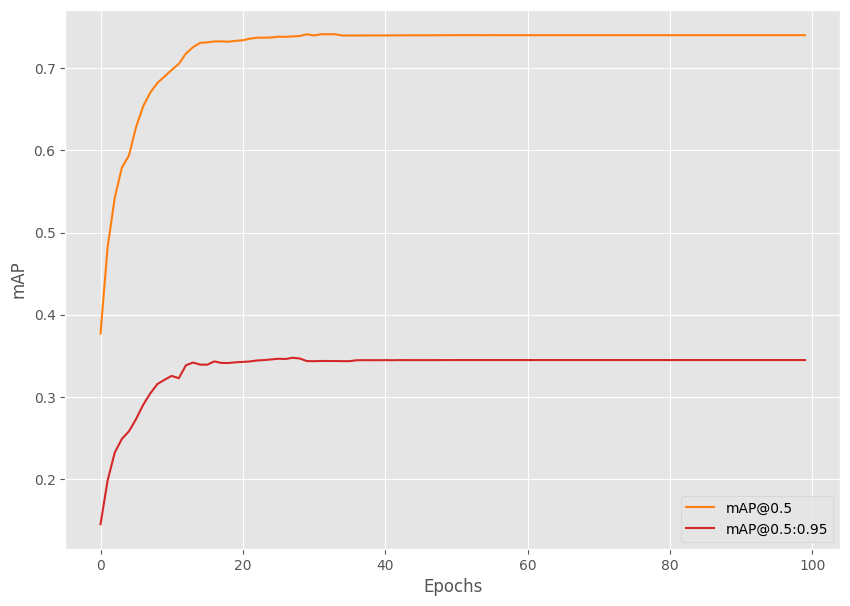

In [16]:
# Initialize a CSV file to store the metrics
csv_file = os.path.join(OUT_DIR, 'training_metrics.csv')
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Train Loss', 'Validation mAP50', 'Validation mAP50-95', 'Learning Rate'])

# To monitor training loss
train_loss_hist = Averager()
# To store training loss and mAP values.
train_loss_list = []
map_50_list = []
map_list = []

# Ensure the model is in training mode
model.train()

save_best_model = SaveBestModel()

# Continue with the training loop
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # Reset the training loss histories for the current epoch.
    train_loss_hist.reset()

    # Start timer and carry out training and validation.
    start = time.time()
    train_loss = train(train_loader, model)
    metric_summary = validate(valid_loader, model)
    
    # Display training loss and validation mAP
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")   
    print(f"Epoch #{epoch+1} mAP@0.5: {metric_summary['map_50']*100:.2f}%")   
    print(f"Epoch #{epoch+1} mAP@0.5:0.95: {metric_summary['map']*100:.2f}%")
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

    # Save the loss and mAP values
    train_loss_list.append(train_loss)
    map_50_list.append(metric_summary['map_50'])
    map_list.append(metric_summary['map'])

    # Save metrics to CSV
    current_lr = scheduler.get_last_lr()[0]  # Get the current learning rate
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, train_loss_hist.value, metric_summary['map_50']*100, metric_summary['map']*100, current_lr])

    # Save the best model till now.
    save_best_model(model, float(metric_summary['map']), epoch, 'outputs')

    # Save the current epoch model.
    save_model(epoch, model, optimizer)

    # Save loss plot.
    save_loss_plot(OUT_DIR, train_loss_list)

    # Save mAP plot.
    save_mAP(OUT_DIR, map_50_list, map_list)

    # Step the scheduler
    scheduler.step()

print(f"Training complete. Metrics saved to {csv_file}")

## Evaluate the model on test data

In [18]:
# Load the best model after training on geospatial dataset
model = create_model(num_classes=NUM_CLASSES, size=RESIZE_TO, weights_path=None)
checkpoint = torch.load("/home/jupyter/ee_tree_counting/Models/SSD/outputs/best_model.pth", map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

# Evaluate on the test dataset
test_dataset = create_valid_dataset("/home/jupyter/ee_tree_counting/Data/GEE Dataset/Dataset XML/test")
test_loader = create_valid_loader(test_dataset, num_workers=NUM_WORKERS)

metric_summary = validate(test_loader, model)
print(f"mAP_50: {metric_summary['map_50']*100:.3f}")
print(f"mAP_50_95: {metric_summary['map']*100:.3f}")


Validating


  0%|          | 0/1 [00:00<?, ?it/s]

mAP_50: 66.083
mAP_50_95: 32.594
